Import the libraries necessary to analize data

In [736]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import random
import seaborn as sns
import plotly.express as px

from collections import defaultdict
from scipy.stats import pearsonr

In [737]:
df = pd.read_csv('incidents_df_joined.csv', low_memory=False, sep=',', parse_dates=['date'])

Change data types to match the content of each attribute (setting to NaN non-numerical values in numerical attributes)

In [738]:
df["date"] = df["date"].astype("datetime64[ns]")
df["state"] = df["state"].astype("string")
df["city_or_county"] = df["city_or_county"].astype("string")
df["address"] = df["address"].astype("string")
df["congressional_district"] = df["congressional_district"].astype("Int64")
df["state_house_district"] = df["state_house_district"].astype("Int64")
df["state_senate_district"] = df["state_senate_district"].astype("Int64")
df["participant_age1"] = df["participant_age1"].astype("Int64")
df["min_age_participants"] = pd.to_numeric(df["min_age_participants"], errors="coerce").astype("Int64")
df["max_age_participants"] = pd.to_numeric(df["max_age_participants"], errors="coerce").astype("Int64")
df["avg_age_participants"] = pd.to_numeric(df["avg_age_participants"], errors="coerce").astype("float64")
df[df['participant_gender1'] == 'Male, female'] = np.nan
df["participant_gender1"] = df["participant_gender1"].astype("string")
df["participant_age_group1"] = df["participant_age_group1"].astype("string")
df["n_participants_teen"] = pd.to_numeric(df["n_participants_teen"], errors="coerce").astype("Int64")
df["n_participants_child"] = pd.to_numeric(df["n_participants_child"], errors="coerce").astype("Int64")
df["n_participants_adult"] = pd.to_numeric(df["n_participants_adult"], errors="coerce").astype("Int64")
df["n_males"] = pd.to_numeric(df["n_males"], errors="coerce").astype("Int64")
df["n_females"] = pd.to_numeric(df["n_females"], errors="coerce").astype("Int64")
df["n_killed"] = pd.to_numeric(df["n_killed"], errors="coerce").astype("Int64")
df["n_injured"] = pd.to_numeric(df["n_injured"], errors="coerce").astype("Int64")
df["n_arrested"] = pd.to_numeric(df["n_arrested"], errors="coerce").astype("Int64")
df["n_unharmed"] = pd.to_numeric(df["n_unharmed"], errors="coerce").astype("Int64")
df["n_participants"] = pd.to_numeric(df["n_participants"], errors="coerce").astype("Int64")
df["notes"] = df["notes"].astype("string")
df["incident_characteristics1"] = df["incident_characteristics1"].astype("string")
df["incident_characteristics2"] = df["incident_characteristics2"].astype("string")
df["party"] = df["party"].astype("string")
df["candidatevotes"] = df["candidatevotes"].astype("Int64")
df["totalvotes"] = df["totalvotes"].astype("Int64")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199379 entries, 0 to 199378
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       199378 non-null  datetime64[ns]
 1   state                      199378 non-null  string        
 2   city_or_county             199378 non-null  string        
 3   address                    185727 non-null  string        
 4   latitude                   199312 non-null  float64       
 5   longitude                  199312 non-null  float64       
 6   congressional_district     199378 non-null  Int64         
 7   state_house_district       178207 non-null  Int64         
 8   state_senate_district      184239 non-null  Int64         
 9   participant_age1           136186 non-null  Int64         
 10  participant_age_group1     161304 non-null  string        
 11  participant_gender1        166715 non-null  string  

Deleting the rows with all NaN values

In [739]:
print(f"df len before: {len(df)}")
df.dropna(how='all', inplace=True)
print(f"df len after: {len(df)}")

df len before: 199379
df len after: 199378


Removing negative values

In [740]:
columns_to_check = ['participant_age1', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants']
# Set values less than 0 to NaN for the specified columns
for i in columns_to_check:
    df.loc[df[i] < 0, i] = np.nan


## Age


As seen in D.U., given that there are some ouliers in the order of ~800 years of age, we decided to remove them by setting them all to NaN, considering that a person with more than 120 years has not ever lived [cite, wikipedia].

In [741]:
df.loc[(df["avg_age_participants"] > 120), "avg_age_participants"] = np.nan
df.loc[(df['min_age_participants'] > 120), "min_age_participants"] = np.nan
df.loc[(df['max_age_participants'] > 120), "max_age_participants"] = np.nan
df.loc[(df["participant_age1"] > 120), "participant_age1"] = np.nan

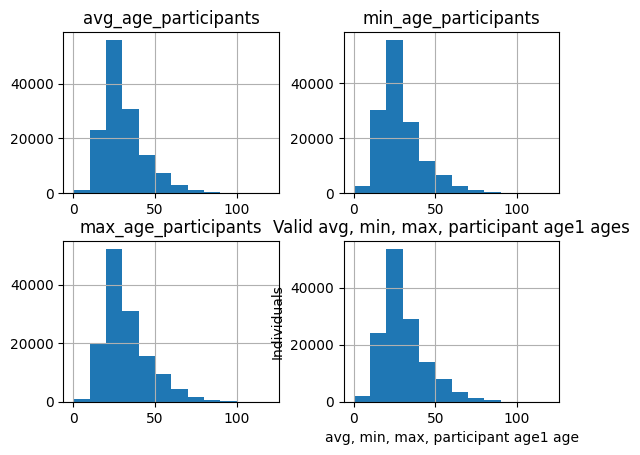

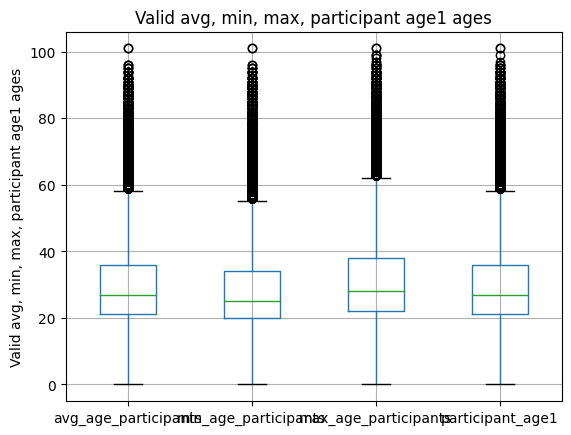

In [742]:

df.hist(column=['avg_age_participants', 'min_age_participants', 'max_age_participants', 'participant_age1'], bins=[i for i in range(0,121,10)])
plt.title("Valid avg, min, max, participant age1 ages")
plt.xlabel("avg, min, max, participant age1 age")
plt.ylabel("Individuals")
plt.show()

df.boxplot(column=['avg_age_participants', 'min_age_participants', 'max_age_participants', 'participant_age1'])
plt.title("Valid avg, min, max, participant age1 ages")
plt.ylabel("Valid avg, min, max, participant age1 ages")
plt.show()

In [743]:
df[['avg_age_participants', 'participant_age1', 'min_age_participants', 'max_age_participants']].describe()

,avg_age_participants,participant_age1,min_age_participants,max_age_participants
count,136184.000000,136184.0,136188.0,136185.0
mean,29.974858,30.260816,28.325763,31.764746
std,12.461499,13.343577,12.498695,13.709934
min,0.000000,0.0,0.0,0.0
25%,21.000000,21.0,20.0,22.0
50%,27.000000,27.0,25.0,28.0
75%,36.000000,36.0,34.0,38.0
max,101.000000,101.0,101.0,101.0


In [744]:
print(f"% of no child in incidents: {df[df['n_participants_child'] == 0]['n_participants_child'].count() / len(df['n_participants_child'])}")
print(f"% of no teen in incidents: {df[df['n_participants_teen'] == 0]['n_participants_teen'].count() / len(df['n_participants_teen'])}")
print(f"% of no adult in incidents: {df[df['n_participants_adult'] == 0]['n_participants_adult'].count() / len(df['n_participants_adult'])}")

% of no child in incidents: 0.7925949703578128
% of no teen in incidents: 0.7222060608492411
% of no adult in incidents: 0.05159546188646691


We notice from eliminated obvious outliers (>120 and <0 years of age) and plotting the results that [avg_age,min_age,max_age]_participants are very similar (same min and max age, similar mean and median), so we decide that we will further explore their correlation. 

We check if when avg_age_participants is 0 or null, we can infer it by calcultating the avg based on min_age_participants and max_age_participants, and we found 0 rows available.
This is a further motivation to delete min and max age participants

In [745]:
df[((df['avg_age_participants'] == 0) | (df['avg_age_participants'].isna())) & (((df['min_age_participants'] > 0) & (df['min_age_participants'].notna())) & ((df['max_age_participants'] > 0) & df['min_age_participants'].notna() ))] [['avg_age_participants', 'min_age_participants', 'max_age_participants']]

,avg_age_participants,min_age_participants,max_age_participants


## Date

Analysis and cleaning of the date attribute

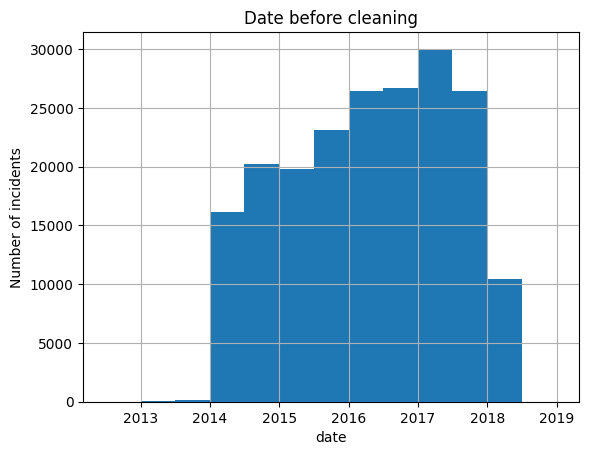

In [746]:
df.hist(column=["date"],   bins=[datetime.datetime(2012,7,1,0,0), datetime.datetime(2013,1,1,0,0), datetime.datetime(2013,7,1,0,0),
                             datetime.datetime(2014,1,1,0,0), datetime.datetime(2014,7,1,0,0), datetime.datetime(2015,1,1,0,0),
                             datetime.datetime(2015,7,1,0,0), datetime.datetime(2016,1,1,0,0), datetime.datetime(2016,7,1,0,0),
                             datetime.datetime(2017,1,1,0,0), datetime.datetime(2017,7,1,0,0), datetime.datetime(2018,1,1,0,0),
                             datetime.datetime(2018,7,1,0,0), datetime.datetime(2019,1,1,0,0)])
plt.title("Date before cleaning")
plt.xlabel("date")
plt.ylabel("Number of incidents")
plt.show()

We considered all dates after 2023-10-01 (the date we received the dataset) to be ouliers, in particular error in the data

TODO: 2018 analyze separately

As seen in D.U., the year 2013 is under represented with only 242 records, so we decide to drop them. 

In [747]:
df['date'].dt.year.value_counts().sort_index()

date
2013      242
2014    36331
2015    42934
2016    53082
2017    56373
2018    10416
Name: count, dtype: int64

In [748]:
df_with_2013 = len(df)
df = df[df['date'].dt.year > 2013]
print(df_with_2013 - len(df))

242


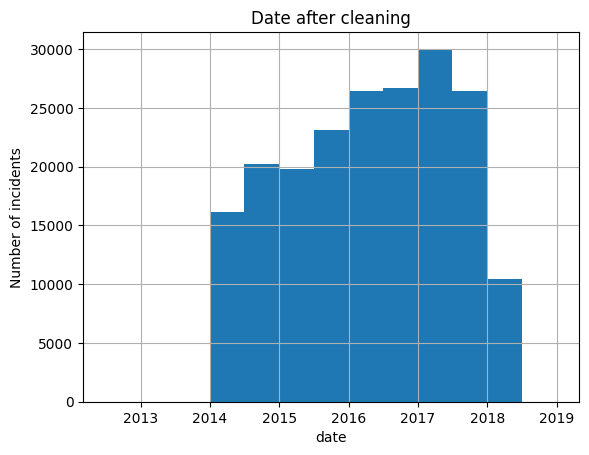

In [749]:
df.hist(column=["date"],   bins=[datetime.datetime(2012,7,1,0,0), datetime.datetime(2013,1,1,0,0), datetime.datetime(2013,7,1,0,0),
                             datetime.datetime(2014,1,1,0,0), datetime.datetime(2014,7,1,0,0), datetime.datetime(2015,1,1,0,0),
                             datetime.datetime(2015,7,1,0,0), datetime.datetime(2016,1,1,0,0), datetime.datetime(2016,7,1,0,0),
                             datetime.datetime(2017,1,1,0,0), datetime.datetime(2017,7,1,0,0), datetime.datetime(2018,1,1,0,0),
                             datetime.datetime(2018,7,1,0,0), datetime.datetime(2019,1,1,0,0)])
plt.title("Date after cleaning")
plt.xlabel("date")
plt.ylabel("Number of incidents")
plt.show()

# Geographical info

## Latitude and longitude

In [750]:
central_block = ((df["latitude"] <= 49.3457868) & (df["latitude"] >= 24.396308) & (df["longitude"] >= -125.000000) & (df["longitude"] <= -66.934570))
alaska_block = ((df["latitude"] <= 71.635993) & (df["latitude"] >= 53.67068) & (df["longitude"] >= -173.59497) & (df["longitude"] <= -129.152344))
hawaii_block = ((df["latitude"] <= 22.674847) & (df["latitude"] >= 17.790535) & (df["longitude"] >= -161.389160) & (df["longitude"] <= -153.237305))

df[~(central_block | alaska_block | hawaii_block)][['latitude', 'longitude']].value_counts(dropna=False)

latitude  longitude
NaN       NaN          66
Name: count, dtype: int64

We consider the triple <date,latitude,longitude> to be a key identifying an incident. We decided to eliminate the records with these 3 values duplicates. 

In [751]:
df[df.duplicated(subset=['latitude', 'longitude', 'date'], keep=False)][['latitude', 'longitude', 'date']].value_counts()

latitude  longitude  date      
36.7387   -119.7900  2018-01-16    6
                     2018-03-17    5
32.7485   -93.9895   2017-01-18    4
32.5512   -93.7045   2016-04-16    4
42.3482   -83.0618   2016-07-04    4
                                  ..
33.6356   -84.4333   2014-02-02    2
                     2014-07-09    2
                     2014-10-09    2
                     2014-10-10    2
61.6139   -149.4510  2016-07-28    2
Name: count, Length: 1134, dtype: int64

In [752]:
print(len(df))
#df = df.drop_duplicates(subset=["date", "latitude", "longitude"]).append(df[pd.isnull(df['date']) | pd.isnull(df['latitude']) | pd.isnull(df['longitude'])])
df = pd.concat([df[pd.isnull(df['date']) | pd.isnull(df['latitude']) | pd.isnull(df['longitude'])], df.drop_duplicates(subset=["date", "latitude", "longitude"])])
df.drop_duplicates(inplace=True)
print(len(df))

199136
197925


In [753]:
df[df.duplicated(subset=['latitude', 'longitude', 'date'], keep=False)][['latitude', 'longitude', 'date']].value_counts()

Series([], Name: count, dtype: int64)

## Filling of missing values and outliers

TODO: check variance

In [754]:
#Sostituisco i valori NaN di latitude e longitude, con i valori delle righe aventi lo stesso state e la stessa city_or_county
df[['latitude', 'longitude']] = df.groupby(["state", "city_or_county"],group_keys=False)[['latitude', 'longitude']].apply(lambda x: x.fillna(x.mean()))
df[['latitude', 'longitude']] = df.groupby("state",group_keys=False)[['latitude', 'longitude']].apply(lambda x: x.fillna(x.mean()))
df[['latitude', 'longitude']].isna().any()

latitude     False
longitude    False
dtype: bool

## Congressional District, State House District, State Senate District

By examining the columns ‘congressional_district’, ‘state_house_district’, and ‘state_senate_district’, we observe that the columns ‘state_house_district’ and ‘state_senate_district’ represent further subdivisions of the US territory, which are not pertinent to our analysis. We will utilize the ‘congressional_district’ column to study the territorial divisions.

In [755]:
df.drop(columns=['state_house_district', 'state_senate_district'], inplace=True)

# Participant quantity information 
('n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants')

#TODO to check..

## N killed, injured, arrested, unharmed

N killed and N injured have no NaN values after the previous steps of cleaning, we proceed to fix N arrested and N unharmed null values.

In [756]:
df[['n_killed', 'n_injured', 'n_arrested', 'n_unharmed']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 197925 entries, 85424 to 199339
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   n_killed    197925 non-null  Int64
 1   n_injured   197925 non-null  Int64
 2   n_arrested  173539 non-null  Int64
 3   n_unharmed  173539 non-null  Int64
dtypes: Int64(4)
memory usage: 8.3 MB


In [757]:
columns_to_check = ['n_killed', 'n_injured', 'n_arrested', 'n_unharmed']
for column in columns_to_check:
    df.loc[df[column] > df['n_participants'], column] = np.nan

In [758]:
df[['n_killed', 'n_injured', 'n_arrested', 'n_unharmed']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 197925 entries, 85424 to 199339
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   n_killed    197925 non-null  Int64
 1   n_injured   197925 non-null  Int64
 2   n_arrested  173539 non-null  Int64
 3   n_unharmed  173539 non-null  Int64
dtypes: Int64(4)
memory usage: 8.3 MB


As we can see, there are no N killed, injured, arrested, unharmed that exceeds the number of participants in that incident

We put to 0 arrested and unharmed in all the cases in which there is 0 participants.

In [759]:
df.loc[df["n_participants"] == 0, ['n_arrested', 'n_unharmed']] = 0

Fill the remaining null values with the mode. # TODO calculate the MAD

In [760]:
def fillna_group_gender(group):
    group["n_arrested"] = group["n_arrested"].fillna(group["n_arrested"].mode(dropna = False)[0])
    group["n_unharmed"] = group["n_unharmed"].fillna(group["n_unharmed"].mode(dropna = False)[0])
    return group

In [761]:
df = df.groupby("n_participants").apply(fillna_group_gender).reset_index(drop=True)

C:\Users\given\AppData\Local\Temp\ipykernel_26220\3093583187.py:3: UserWarning: Unable to sort modes: boolean value of NA is ambiguous
  group["n_unharmed"] = group["n_unharmed"].fillna(group["n_unharmed"].mode(dropna = False)[0])


In [762]:
df[['n_killed', 'n_injured', 'n_arrested', 'n_unharmed']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197925 entries, 0 to 197924
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   n_killed    197925 non-null  Int64
 1   n_injured   197925 non-null  Int64
 2   n_arrested  197925 non-null  Int64
 3   n_unharmed  197924 non-null  Int64
dtypes: Int64(4)
memory usage: 6.8 MB


In [763]:
df[df['n_participants'] == 30][['n_participants', 'n_killed', 'n_injured', 'n_arrested', 'n_unharmed', 'incident_characteristics1']].tail(10)

,n_participants,n_killed,n_injured,n_arrested,n_unharmed,incident_characteristics1
197916,30,0,0,30,0,Non-Shooting Incident


## N participants [child, teen, adult] and n males and n females

As we observed in D.U., for n_participants[_child,_teen,_adult] there are outliers represented by enormous values. In data preparation, we decided to clean these data putting them to nan.

In [764]:
# n_participants has no evident outliers as seen in D.U., we use max participants as threshold value to filter out the outliers
max_participants = df['n_participants'].max()

df.loc[(df["n_participants_child"] > max_participants), "n_participants_child"] = np.nan
df.loc[(df["n_participants_teen"] > max_participants), "n_participants_teen"] = np.nan
df.loc[(df["n_participants_adult"] > max_participants), "n_participants_adult"] = np.nan

If n participants 0, fill all the other info about the number of people to 0

In [765]:
df.loc[df["n_participants"] == 0, ["n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"]] = 0

In [766]:
#Utilizzerà questi valori per sosituire "n_participants" nel caso somma tra male e female è pari alla somma tra teen,child e adults.
#La modifica per quanto riguarda "n_participants" è fatta solo se è diversa da tutte le altre somme delle varie colonne:
#1) females + males
#2) child + adult + teen
#3) killed+injured+unharmed+arrested

#Nel caso in cui n_participants sia almeno uguale ad una delle altre somme => lascia uguale.
df['substitute_values'] = df['n_females'] + df['n_males']

# Define the condition for substitution
condition = (
    ((df['n_females'] + df['n_males']) == (df['n_participants_teen'] + df['n_participants_child'] + df['n_participants_adult'])) &
    (df['n_participants'] != (df['n_females'] + df['n_males'])) 
)

# Update the "n_participants" column with the calculated values where the condition is met
df.loc[condition, 'n_participants'] = df.loc[condition, 'substitute_values']

# Drop the temporary "substitute_values" column if needed
df.drop(columns='substitute_values', inplace=True)

df[condition][["n_participants","n_males","n_females", "n_participants_teen", "n_participants_child", "n_participants_adult"]]

,n_participants,n_males,n_females,n_participants_teen,n_participants_child,n_participants_adult
108152,1,1,0,0,0,1
108157,1,1,0,0,0,1
108186,1,1,0,0,0,1
108189,1,0,1,0,0,1
108224,1,1,0,0,0,1
...,...,...,...,...,...,...
197862,1,1,0,0,0,1
197867,14,12,2,4,0,10
197906,22,18,4,0,0,22
197908,20,13,7,8,0,12


In [767]:
df['n_participants_gender'] = df['n_females'] + df['n_males']
df['n_participants_age'] = df['n_participants_teen'] + df['n_participants_child'] + df['n_participants_adult']

# null values can be ambiguous, we ignore them for now
df['n_participants_gender'] = df[df['n_participants_gender'].notna()]['n_participants_gender']
df['n_participants_age'] = df[df['n_participants_age'].notna()]['n_participants_age']


condition = (
    ((df['n_participants_gender']) != (df['n_participants_age']))   
)

print(f"Number of male e female != child + teen + adult:  {len(df[condition])}")

condition1 = condition & ((df['n_participants'] == (df['n_participants_gender'])))

print(f"Same condition as before but with n participants == female + male: {len(df[condition1])}")

condition2 = condition & ((df['n_participants'] == (df['n_participants_age'])) )

print(f"Same condition as before but with n participants == child + teen + adult: {len(df[condition2])}")

condition3 = condition & (((df['n_participants'] != df['n_participants_gender']) & (df['n_participants'] != df['n_participants_age'])))
                          
print(f"Same condition as before but with n participants != child + teen + adult and != n_males + n_females: {len(df[condition3])}")


Number of male e female != child + teen + adult:  13363
Same condition as before but with n participants == female + male: 8649
Same condition as before but with n participants == child + teen + adult: 4202
Same condition as before but with n participants != child + teen + adult and != n_males + n_females: 512


In [768]:
df.loc[condition3, ["n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females","n_participants_age","n_participants_gender"]] = np.nan
df.loc[condition2, ["n_males","n_females","n_participants_gender"]] = np.nan
df.loc[condition1, ["n_participants_child","n_participants_teen", "n_participants_adult","n_participants_age"]] = np.nan
df.loc[df["n_participants_age"] != df["n_participants"],["n_participants_child","n_participants_teen", "n_participants_adult","n_participants_age"]] = np.nan
df.loc[df["n_participants_gender"] != df["n_participants"],["n_males","n_females", "n_participants_gender"]] = np.nan


In [769]:
df[["n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197925 entries, 0 to 197924
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   n_participants_child  172824 non-null  Int64
 1   n_participants_teen   172824 non-null  Int64
 2   n_participants_adult  172824 non-null  Int64
 3   n_males               181641 non-null  Int64
 4   n_females             181641 non-null  Int64
dtypes: Int64(5)
memory usage: 8.5 MB


In [770]:
df[df["n_participants"] == 11][["n_participants","n_males","n_females",'n_participants_teen','n_participants_child','n_participants_adult']]


,n_participants,n_males,n_females,n_participants_teen,n_participants_child,n_participants_adult
197790,11,9,2,2,0,9
197791,11,<NA>,<NA>,<NA>,<NA>,<NA>
197792,11,8,3,0,0,11
197793,11,11,0,0,0,11
197794,11,9,2,0,4,7
197795,11,<NA>,<NA>,10,1,0
197796,11,10,1,9,0,2
197797,11,<NA>,<NA>,0,2,9
197798,11,9,2,0,0,11
197799,11,7,4,<NA>,<NA>,<NA>


In [771]:
#putting in males the first element from males_females
group_by = df.groupby("n_participants",group_keys=False)
for name, group in group_by:
    print("name::",name)
    males_mean = group["n_males"].mean()
    females_mean = group["n_females"].mean()
    participants_child_mean = group["n_participants_child"].mean()
    participants_teen_mean = group["n_participants_teen"].mean()
    participants_adult_mean = group["n_participants_adult"].mean()

    if (pd.notna(males_mean) and pd.notna(females_mean)):
        df.loc[(df["n_males"].isna()) & (df["n_participants"] == name),"n_males"] = np.round(males_mean,0)
        df.loc[(df["n_females"].isna()) & (df["n_participants"] == name),"n_females"] = np.round(females_mean,0)

    if (pd.notna(participants_child_mean) and pd.notna(participants_teen_mean) and pd.notna(participants_adult_mean)):
        df.loc[(df["n_participants_child"].isna()) & (df["n_participants"] == name),"n_participants_child"] = np.round(participants_child_mean,0)
        df.loc[(df["n_participants_teen"].isna()) & (df["n_participants"] == name),"n_participants_teen"] = np.round(participants_teen_mean,0)
        df.loc[(df["n_participants_adult"].isna()) & (df["n_participants"] == name),"n_participants_adult"] = np.round(participants_adult_mean,0)


#Fatto dal real one, The O.G. Hamza Karoui

name:: 0
name:: 1
name:: 2
name:: 3
name:: 4
name:: 5
name:: 6
name:: 7
name:: 8
name:: 9
name:: 10
name:: 11
name:: 12
name:: 13
name:: 14
name:: 15
name:: 16
name:: 17
name:: 18
name:: 19
name:: 20
name:: 21
name:: 22
name:: 24
name:: 26
name:: 27
name:: 29
name:: 30
name:: 32
name:: 35
name:: 37
name:: 47
name:: 52
name:: 63
name:: 103


In [772]:
df[df["n_participants"] == 11][["n_participants","n_males","n_females",'n_participants_teen','n_participants_child','n_participants_adult']]


,n_participants,n_males,n_females,n_participants_teen,n_participants_child,n_participants_adult
197790,11,9,2,2,0,9
197791,11,9,2,1,1,9
197792,11,8,3,0,0,11
197793,11,11,0,0,0,11
197794,11,9,2,0,4,7
197795,11,9,2,10,1,0
197796,11,10,1,9,0,2
197797,11,9,2,0,2,9
197798,11,9,2,0,0,11
197799,11,7,4,1,1,9


In [773]:
df[["n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"]].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197925 entries, 0 to 197924
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   n_participants_child  197922 non-null  Int64
 1   n_participants_teen   197922 non-null  Int64
 2   n_participants_adult  197922 non-null  Int64
 3   n_males               197917 non-null  Int64
 4   n_females             197917 non-null  Int64
dtypes: Int64(5)
memory usage: 8.5 MB


All the wrong data were corrected

In [779]:
print(len(df[(df["n_males"].isna() & df["n_females"].isna()) | (df['n_participants_teen'].isna() & df['n_participants_child'].isna() & df['n_participants_adult'].isna())]))


8


In [774]:
condition = (
    ((df['n_females'] + df['n_males']) != (df['n_participants_teen'] + df['n_participants_child'] + df['n_participants_adult']))   
)

print(f"Number of male e female != child + teen + adult:  {len(df[condition])}")

Number of male e female != child + teen + adult:  3


In [335]:
df.loc[condition, ["n_participants","n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"]].value_counts()

n_participants  n_participants_child  n_participants_teen  n_participants_adult  n_males  n_females
2               0                     0                    2                     1        0            676
3               0                     0                    3                     2        0            185
2               0                     0                    1                     2        0            113
3               0                     0                    3                     1        0            106
4               0                     0                    4                     3        0             52
                                                                                                      ... 
5               0                     0                    5                     0        2              1
4               0                     1                    0                     4        0              1
                                      0     

In [336]:
df[['n_participants',"n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"]].tail(10)

,n_participants,n_participants_child,n_participants_teen,n_participants_adult,n_males,n_females
197915,29,0,0,29,29,0
197916,30,0,0,30,<NA>,<NA>
197917,32,0,0,32,26,6
197918,35,<NA>,<NA>,<NA>,<NA>,<NA>
197919,35,0,27,8,17,18
197920,37,<NA>,<NA>,<NA>,<NA>,<NA>
197921,47,<NA>,<NA>,<NA>,<NA>,<NA>
197922,52,<NA>,<NA>,<NA>,<NA>,<NA>
197923,63,0,0,63,60,3
197924,103,0,0,103,<NA>,<NA>


# Poverty by State

# Year State District House

# Correlation Matrix Analysis

In [ ]:
corr_matrix = df[['participant_age1', 'participant_age_group1',
       'participant_gender1', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants', 'povertyPercentage']].corr(numeric_only=True, method='pearson')
corr_matrix

,participant_age1,min_age_participants,avg_age_participants,max_age_participants,n_participants_child,n_participants_teen,n_participants_adult,n_males,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,povertyPercentage
participant_age1,1.000000,0.878249,0.945374,0.926564,-0.178301,-0.266419,0.124992,-0.059440,0.069607,0.141313,-0.119291,-0.025399,-0.008497,-0.032136,0.033251
min_age_participants,0.878249,1.000000,0.951471,0.812026,-0.229141,-0.310949,-0.008111,-0.184504,-0.016675,0.058124,-0.149901,-0.107940,-0.045705,-0.177151,0.013513
avg_age_participants,0.945374,0.951471,1.000000,0.948585,-0.176403,-0.296951,0.103170,-0.093306,0.064925,0.131659,-0.118609,-0.052422,-0.020679,-0.064166,0.029988
max_age_participants,0.926564,0.812026,0.948585,1.000000,-0.108850,-0.244139,0.215472,0.020418,0.144231,0.192128,-0.072814,0.021741,0.009877,0.069072,0.043052
n_participants_child,-0.178301,-0.229141,-0.176403,-0.108850,1.000000,0.005375,-0.024219,0.046076,0.163545,0.063619,0.058783,-0.028941,0.125246,0.140539,0.033858
n_participants_teen,-0.266419,-0.310949,-0.296951,-0.244139,0.005375,1.000000,-0.190457,0.199883,0.065621,-0.004085,0.100267,0.163419,0.058933,0.225725,0.011304
n_participants_adult,0.124992,-0.008111,0.103170,0.215472,-0.024219,-0.190457,1.000000,0.725036,0.348240,0.237241,0.266737,0.384337,0.347131,0.814776,0.076883
n_males,-0.059440,-0.184504,-0.093306,0.020418,0.046076,0.199883,0.725036,1.000000,-0.058029,0.141565,0.252602,0.390963,0.415403,0.826406,0.053575
n_females,0.069607,-0.016675,0.064925,0.144231,0.163545,0.065621,0.348240,-0.058029,1.000000,0.191527,0.156243,0.119836,0.134293,0.379613,0.055389
n_killed,0.141313,0.058124,0.131659,0.192128,0.063619,-0.004085,0.237241,0.141565,0.191527,1.000000,-0.121676,-0.070111,-0.134554,0.258198,0.065294


<Axes: >

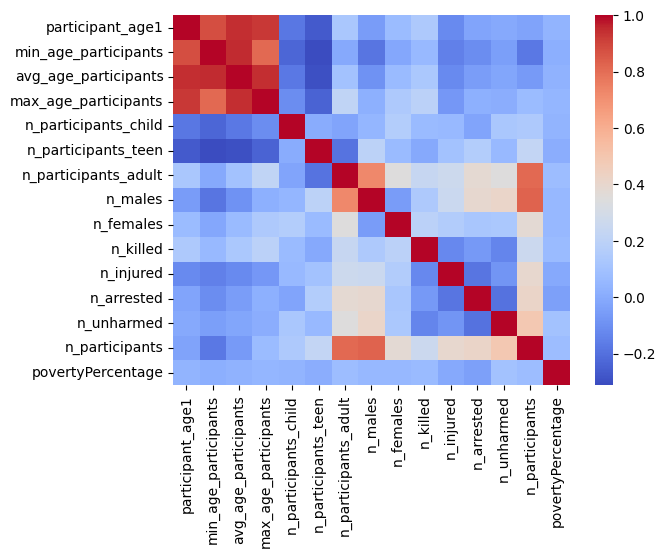

In [ ]:
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')

# Definition of Index 

In [ ]:
#How many males are involved in incidents w.r.t. the total number of males for the
#same city and in the same period?
df["males_percentage"] = df["n_males"] /  df.groupby(["year","state", "city_or_county"])["n_males"].transform("sum")
df["males_percentage"]

85424          1.0
87060     0.066667
154437    0.002506
162475         1.0
162702    0.021277
            ...   
199335         1.0
199336         1.0
199337         NaN
199338         1.0
199339         1.0
Name: males_percentage, Length: 197925, dtype: Float64

In [ ]:
#How many killed people have been involved w.r.t the total killed people in
# the same congressional district in a given period of time?
df["killed_percentage"] = df["n_killed"] /  df.groupby(["year","state", "congressional_district" ])["n_killed"].transform("sum")
df["killed_percentage"]

85424     0.0
87060     0.0
154437    0.0
162475    0.0
162702    0.0
         ... 
199335    NaN
199336    NaN
199337    NaN
199338    NaN
199339    NaN
Name: killed_percentage, Length: 197925, dtype: Float64

In [ ]:
#How many injured people have been involved w.r.t the total injured people in
# the same congressional district in a given period of time?
df["injured_percentage"] = df["n_injured"] /  df.groupby(["year","state", "congressional_district" ])["n_injured"].transform("sum")


In [ ]:
#Ratio of the number of the killed people in the incidents w.r.t. the number of
#participants in the incident
df["killed_percentage_per_incident"] = df["n_killed"] / df["n_participants"]
df[["n_killed", "n_participants", "killed_percentage_per_incident"]]

,n_killed,n_participants,killed_percentage_per_incident
85424,0,1,0.0
87060,0,1,0.0
154437,0,2,0.0
162475,0,1,0.0
162702,0,1,0.0
...,...,...,...
199335,0,2,0.0
199336,0,1,0.0
199337,0,1,0.0
199338,0,3,0.0


In [ ]:
#Ratio of unharmed people in the incidents w.r.t. the the average of unharmed people
#in the same period
df["unharmed_percentage"] = df["n_unharmed"] / df.groupby(["year"])["n_unharmed"].transform("mean")
df[["n_unharmed", "unharmed_percentage"]]

,n_unharmed,unharmed_percentage
85424,0,0.0
87060,0,0.0
154437,0,0.0
162475,0,0.0
162702,0,0.0
...,...,...
199335,0,0.0
199336,1,3.49192
199337,0,0.0
199338,0,0.0


# Attributes dropped

As observed in the DU address will be dropped, moreover we will drop also year and notes because the former is a result of the data integration, useless because is redundant as we have the attribute date, the latter is useless because is only a string of text, used only in the data understanding

In [ ]:
df.drop(columns=['notes', 'year', 'address'], inplace=True)

# Export the dataframe after the data preparation

In [ ]:
df.to_csv('df_after_dp.csv', index=False)